In [19]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
!pip install xgboost
import xgboost as xgb
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

Import the data sets

In [20]:
def load_data(df):
  print('Loading data...')
  df = pd.read_csv(df)
  return df

In [21]:
churn_predictive_data_cleaned = load_data('/content/churn_predictive_data_cleaned.csv')
churn_predictive_data_cleaned.drop(['CustomerID', 'last_interaction', 'resolved_interactions', 'LastLoginDate'], axis=1, inplace=True)
print(churn_predictive_data_cleaned.head())

Loading data...
   Age Gender MaritalStatus IncomeLevel  ChurnStatus  TotalAmountSpent  \
0   62      M        Single         Low            0            416.50   
1   65      M       Married         Low            1           1547.42   
2   18      M        Single         Low            0           1702.98   
3   21      M       Widowed         Low            0            917.29   
4   57      F      Divorced      Medium            0           1164.29   

   AverageAmountSpent  NumberOfTransactions  number_of_interactions  \
0             416.500                     1                     1.0   
1             221.060                     7                     1.0   
2             283.830                     6                     1.0   
3             183.458                     5                     2.0   
4             232.858                     5                     1.0   

   resolution_rate  LoginFrequency ServiceUsage  Recency  
0              1.0              34   Mobile App      

In [22]:
def encoding(df):
  print('Encoding data...')
  df['Gender'] = df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})
  df['MaritalStatus'] = df['MaritalStatus'].map({'Single': 0, 'Married': 1, 'Widowed': 2, 'Divorced': 3, 'Unknown': 4})
  df['ServiceUsage'] = df['ServiceUsage'].map({'Mobile App': 0, 'Website': 1, 'Online Banking': 2})
  df['IncomeLevel'] = df['IncomeLevel'].map({'Low': 0, 'Medium': 1, 'High': 2})
  return df


churn_predictive_data_encoded = encoding(churn_predictive_data_cleaned)
print(churn_predictive_data_encoded.head())

Encoding data...
   Age  Gender  MaritalStatus  IncomeLevel  ChurnStatus  TotalAmountSpent  \
0   62       0              0            0            0            416.50   
1   65       0              1            0            1           1547.42   
2   18       0              0            0            0           1702.98   
3   21       0              2            0            0            917.29   
4   57       1              3            1            0           1164.29   

   AverageAmountSpent  NumberOfTransactions  number_of_interactions  \
0             416.500                     1                     1.0   
1             221.060                     7                     1.0   
2             283.830                     6                     1.0   
3             183.458                     5                     2.0   
4             232.858                     5                     1.0   

   resolution_rate  LoginFrequency  ServiceUsage  Recency  
0              1.0              3

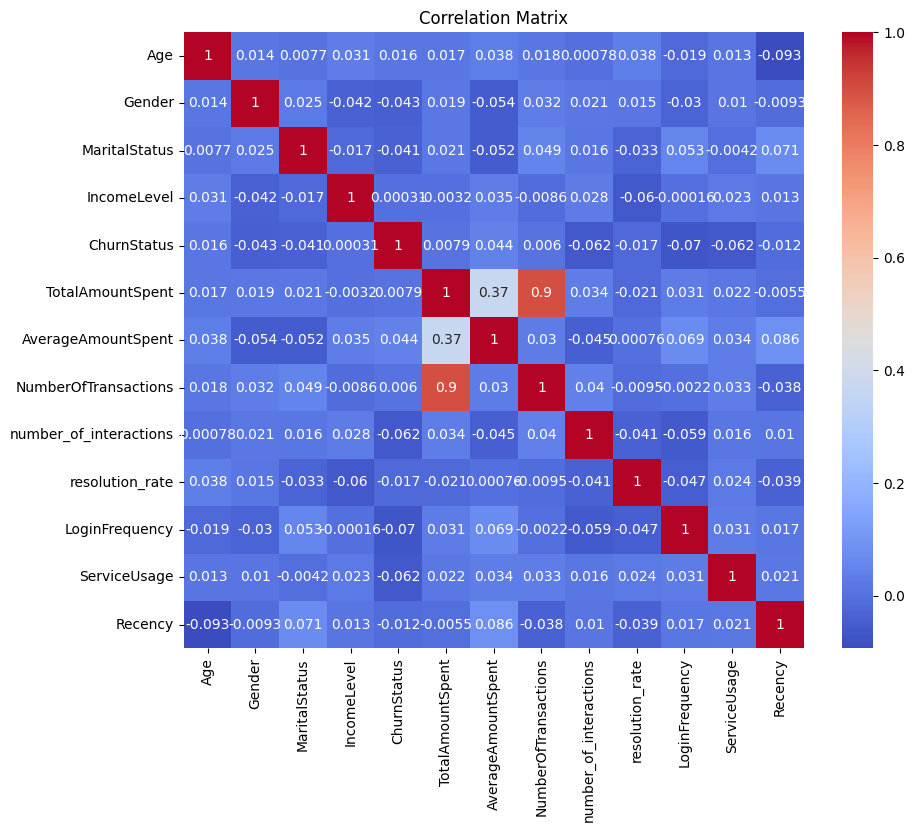

In [23]:
cor_matrix = churn_predictive_data_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Train-Test split (80/20)

In [24]:
X = churn_predictive_data_encoded.drop('ChurnStatus', axis=1)
y = churn_predictive_data_encoded['ChurnStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((534, 12), (134, 12))

# SMOTE analysis

In [25]:
churn_predictive_data_encoded['ChurnStatus'].value_counts()

,count
ChurnStatus,
0,525
1,143


We can see a class of imbalance where the no churn status (525) is higher than those who churn (143).

Which method will be best to oversample/unsample synthetic data for this churn analysis?

- SMOTE

# Lasso Regression

Selected features:
['number_of_interactions', 'LoginFrequency', 'ServiceUsage']


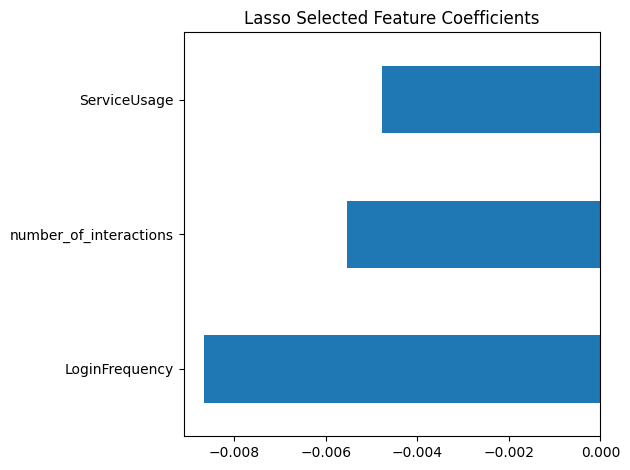

<Figure size 640x480 with 0 Axes>

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Coefficients of each feature
coef = pd.Series(lasso.coef_, index=X.columns)

# Filter out the zero coefficients (i.e., features selected by Lasso)
selected_features = coef[coef != 0].index.tolist()

print("Selected features:")
print(selected_features)


if not coef[coef != 0].empty:
    coef[coef != 0].sort_values().plot(kind='barh', title="Lasso Selected Feature Coefficients")
    plt.tight_layout()
    plt.show()
else:
    print("No features were selected by the Lasso model.")

plt.tight_layout()
plt.show()

# Logistic Regression

In [27]:
pipeline_lr = Pipeline([
    ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.80      0.72      0.76       107
           1       0.21      0.30      0.25        27

    accuracy                           0.63       134
   macro avg       0.51      0.51      0.50       134
weighted avg       0.68      0.63      0.66       134



In [28]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       107
           1       0.21      0.30      0.25        27

    accuracy                           0.63       134
   macro avg       0.51      0.51      0.50       134
weighted avg       0.68      0.63      0.66       134



# Decision Tree

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       107
           1       0.16      0.22      0.18        27

    accuracy                           0.60       134
   macro avg       0.47      0.46      0.46       134
weighted avg       0.66      0.60      0.63       134

ROC_AUC: 0.46157840083073726


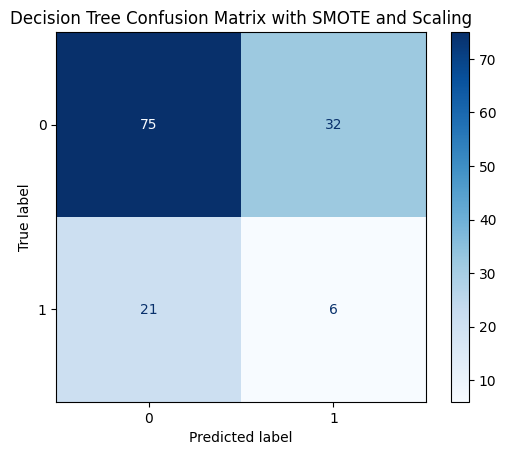

[[75 32]
 [21  6]]


In [29]:
pipeline_dt = Pipeline([
    ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42)),
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier())
])

pipeline_dt.fit(X_train, y_train)
y_pred_dt = pipeline_dt.predict(X_test)
y_pred_proba_dt = pipeline_dt.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_dt))
print("ROC_AUC:", roc_auc_score(y_test, y_pred_dt))


cm_dt = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp.plot(cmap='Blues')
plt.title('Decision Tree Confusion Matrix with SMOTE and Scaling')
plt.show()
print(cm_dt)

In [30]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt2 = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt2))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       107
           1       0.30      0.30      0.30        27

    accuracy                           0.72       134
   macro avg       0.56      0.56      0.56       134
weighted avg       0.72      0.72      0.72       134



# Random Forest

ROC-AUC: 0.5273451021114572
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       107
           1       0.29      0.15      0.20        27

    accuracy                           0.75       134
   macro avg       0.55      0.53      0.52       134
weighted avg       0.70      0.75      0.72       134



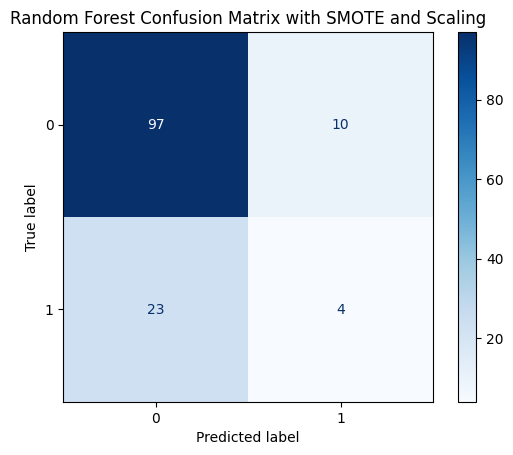

[[97 10]
 [23  4]]


In [31]:
pipeline_rf = Pipeline([
    ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=10, min_samples_leaf=2))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


cm_rf = confusion_matrix(y_test, y_pred_rf)
# Correct the variable name passed to ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix with SMOTE and Scaling') # Add a title for clarity
plt.show()
# Print the calculated confusion matrix
print(cm_rf)

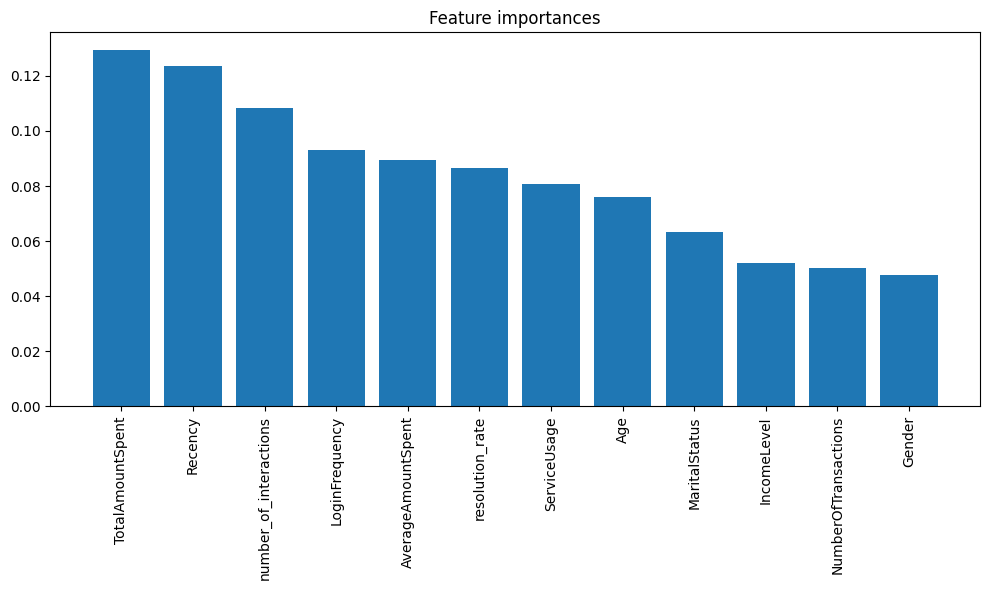

In [32]:
importances = pipeline_rf['model'].feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [33]:
grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


for n_estimators in grid_params['n_estimators']:
    for max_depth in grid_params['max_depth']:
        for min_samples_split in grid_params['min_samples_split']:
            for min_samples_leaf in grid_params['min_samples_leaf']:
                print(f"Training model with n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
                rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
                rf.fit(X_train, y_train)
                y_pred = rf.predict(X_test)
                print(classification_report(y_test, y_pred))
                print("ROC_AUC:", roc_auc_score(y_test, y_pred))

Training model with n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=1
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       107
           1       0.00      0.00      0.00        27

    accuracy                           0.78       134
   macro avg       0.40      0.49      0.44       134
weighted avg       0.64      0.78      0.70       134

ROC_AUC: 0.49065420560747663
Training model with n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       107
           1       0.00      0.00      0.00        27

    accuracy                           0.78       134
   macro avg       0.40      0.49      0.44       134
weighted avg       0.63      0.78      0.70       134

ROC_AUC: 0.48598130841121495
Training model with n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=4
         

Training model with n_estimators=50, max_depth=20, min_samples_split=10, min_samples_leaf=2
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       107
           1       0.00      0.00      0.00        27

    accuracy                           0.80       134
   macro avg       0.40      0.50      0.44       134
weighted avg       0.64      0.80      0.71       134

ROC_AUC 0.5




Training model with n_estimators=50, max_depth=30, min_samples_split=10, min_samples_leaf=4
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       107
           1       0.00      0.00      0.00        27

    accuracy                           0.80       134
   macro avg       0.40      0.50      0.44       134
weighted avg       0.64      0.80      0.71       134

ROC_AUC 0.5




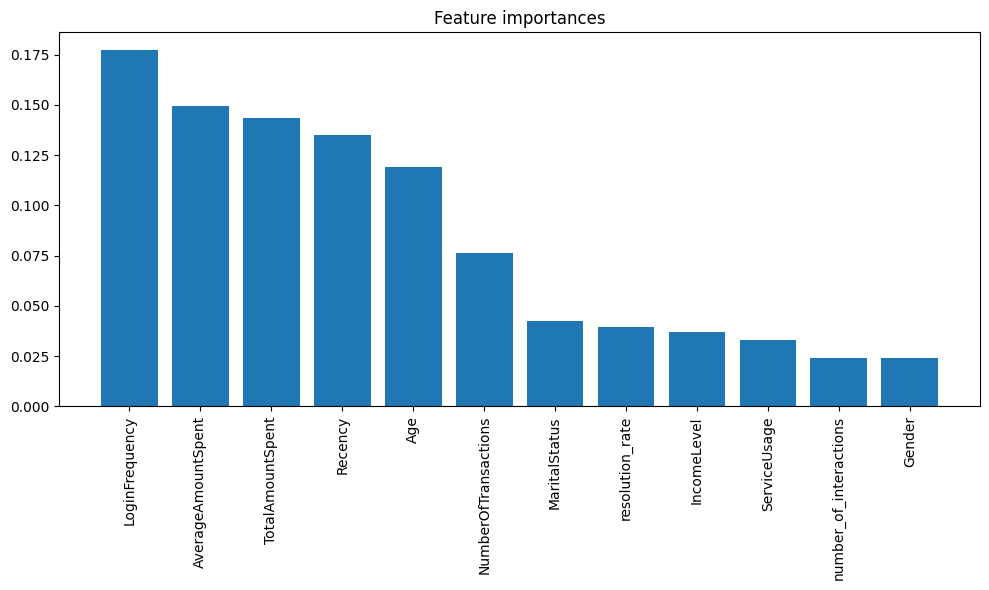

In [34]:
#rf important features
rf_chosen = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split=10, min_samples_leaf=2)
rf_chosen.fit(X_train, y_train)
importances = rf_chosen.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# XGBoost

ROC-AUC: 0.566632052613361
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       107
           1       0.21      0.15      0.17        27

    accuracy                           0.72       134
   macro avg       0.51      0.50      0.50       134
weighted avg       0.68      0.72      0.70       134



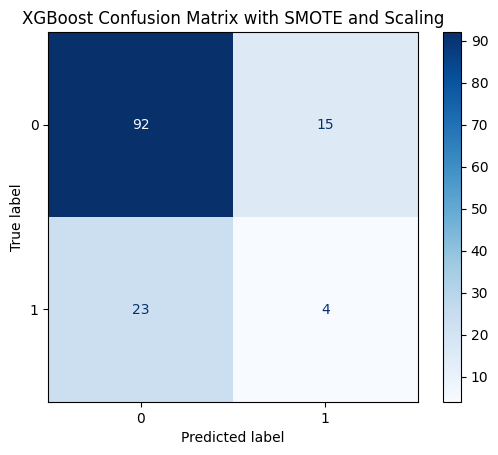

[[92 15]
 [23  4]]


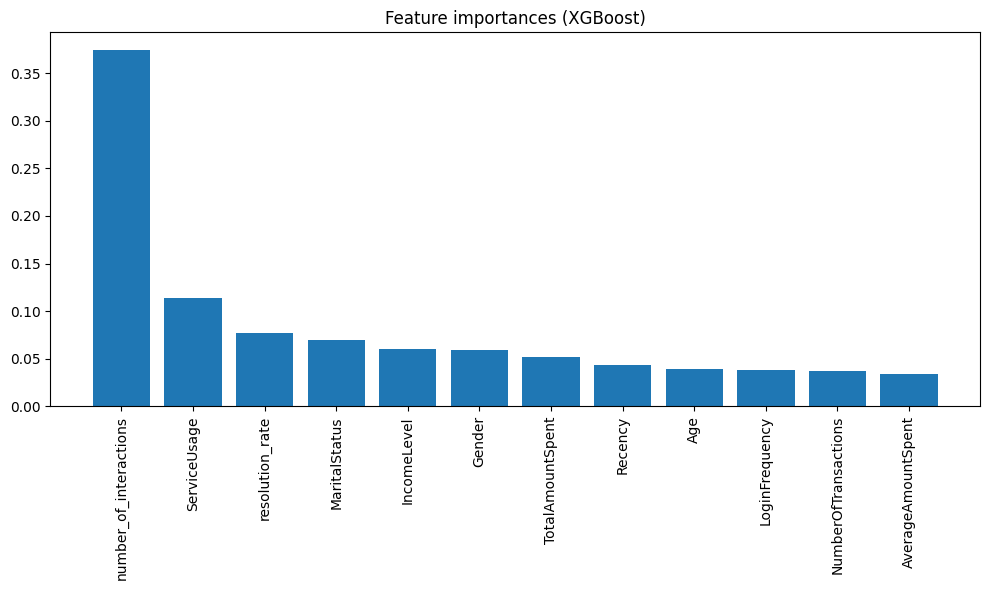

In [35]:
pipeline_xgb = Pipeline([
    ('SMOTE', SMOTE(sampling_strategy='auto', random_state=42)),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss'))
])

pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb)) # Use probability for ROC-AUC
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix with SMOTE and Scaling')
plt.show()
print(cm_xgb)

# Feature importances for XGBoost (from the fitted model in the pipeline)
importances = pipeline_xgb['model'].feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.title("Feature importances (XGBoost)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()



In [36]:
# Optional: Hyperparameter tuning for XGBoost
grid_params_xgb = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(pipeline_xgb, grid_params_xgb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best parameters found: ", grid_search_xgb.best_params_)
print("Best ROC-AUC score: ", grid_search_xgb.best_score_)

best_xgb_model = grid_search_xgb.best_estimator_
y_pred_tuned = best_xgb_model.predict(X_test)
y_pred_proba_tuned = best_xgb_model.predict_proba(X_test)[:, 1]

print("\nClassification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred_tuned))
print("ROC-AUC (Tuned XGBoost):", roc_auc_score(y_test, y_pred_proba_tuned))

Best parameters found:  {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}
Best ROC-AUC score:  0.5940625521560773

Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       107
           1       0.23      0.19      0.20        27

    accuracy                           0.71       134
   macro avg       0.52      0.51      0.51       134
weighted avg       0.69      0.71      0.70       134

ROC-AUC (Tuned XGBoost): 0.5870543440636898


# Neural Networks

Training Neural Network...
Neural Network Test Loss: 0.7940
Neural Network Test Accuracy: 0.6716
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       107
           1       0.21      0.22      0.21        27

    accuracy                           0.67       134
   macro avg       0.50      0.50      0.50       134
weighted avg       0.68      0.67      0.68       134

Neural Network ROC_AUC: 0.5095188646590516


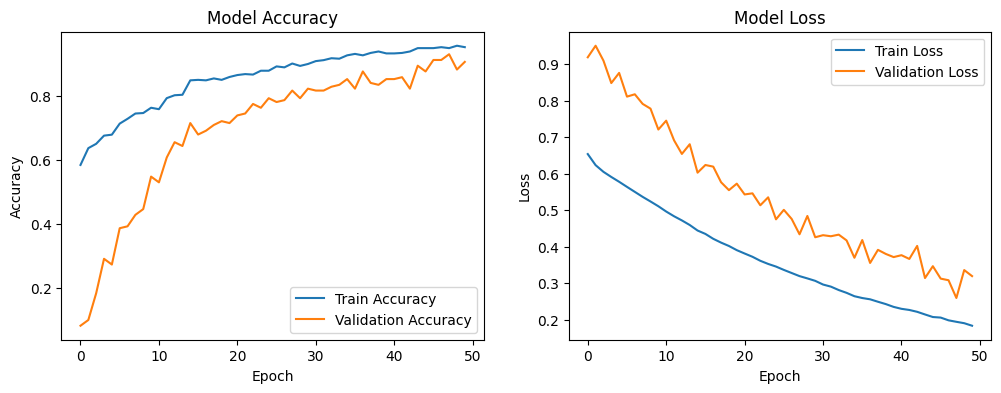

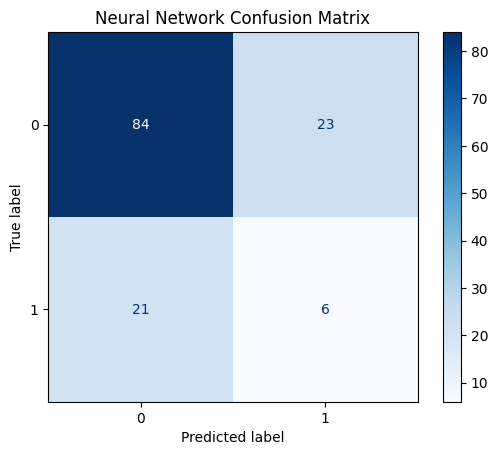

In [37]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Build the Neural Network model
model = Sequential()
model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
print("Training Neural Network...")
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Network Test Loss: {loss:.4f}")
print(f"Neural Network Test Accuracy: {accuracy:.4f}")

# Predictions and evaluation metrics
y_pred_nn = model.predict(X_test_scaled)
y_pred_nn_classes = (y_pred_nn > 0.5).astype("int32")

print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred_nn_classes))

print("Neural Network ROC_AUC:", roc_auc_score(y_test, y_pred_nn))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn)
disp_nn.plot(cmap='Blues')
plt.title('Neural Network Confusion Matrix')
plt.show()



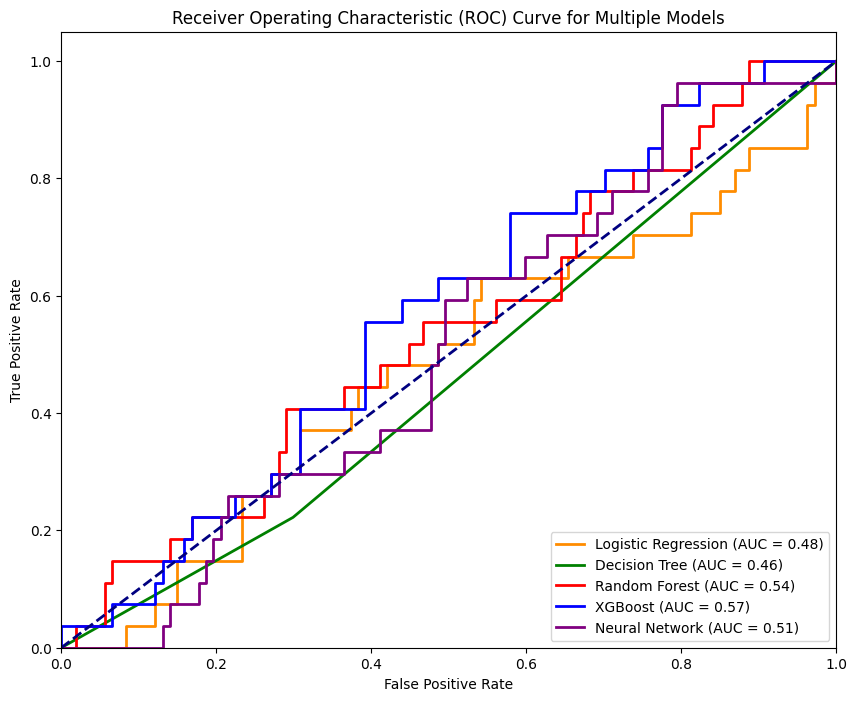

In [38]:
'''
ROC curve and AUC for each model
'''
# Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, pipeline_lr.predict_proba(X_test)[:, 1])
lr_auc = auc(lr_fpr, lr_tpr)

# Decision Tree
dt_fpr, dt_tpr, _ = roc_curve(y_test, pipeline_dt.predict_proba(X_test)[:, 1]) # Using pipeline model for consistency
dt_auc = auc(dt_fpr, dt_tpr)

# Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, pipeline_rf.predict_proba(X_test)[:, 1]) # Using pipeline model for consistency
rf_auc = auc(rf_fpr, rf_tpr)

#XGBoost
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, pipeline_xgb.predict_proba(X_test)[:, 1]) # Using pipeline model for consistency
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Neural Network
nn_fpr, nn_tpr, _ = roc_curve(y_test, y_pred_nn)
nn_auc = auc(nn_fpr, nn_tpr)


plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, color='green', lw=2, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='red', lw=2, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, color='blue', lw=2, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(nn_fpr, nn_tpr, color='purple', lw=2, label=f'Neural Network (AUC = {nn_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiple Models')
plt.legend(loc="lower right")
plt.show()